In [5]:
from __future__ import division, print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
import os
%matplotlib inline

In [10]:
os.getcwd()

'/home/ubuntu/siamese'

In [11]:
DATA_DIR = ""
IMAGE_DIR = os.path.join(DATA_DIR, "images")

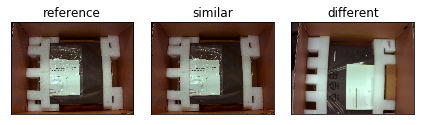

In [39]:
ref_image = plt.imread(os.path.join(IMAGE_DIR, "060001.jpg"))
sim_image = plt.imread(os.path.join(IMAGE_DIR, "060002.jpg"))
dif_image = plt.imread(os.path.join(IMAGE_DIR, "080001.jpg"))

def draw_image(subplot, image, title):
    plt.subplot(subplot)
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
draw_image(131, ref_image, "reference")
draw_image(132, sim_image, "similar")
draw_image(133, dif_image, "different")
plt.tight_layout()
plt.show()

In [23]:
image_groups = {}
for image_name in os.listdir(IMAGE_DIR):
    base_name = image_name[2:-4]
    group_name = base_name[0:2]
    if group_name in image_groups:
        image_groups[group_name].append(image_name)
    else:
        image_groups[group_name] = [image_name]

num_sim = 0
image_triples = []
group_list = sorted(list(image_groups.keys()))
for i, g in enumerate(group_list):
    if num_sim % 100 == 0:
        print("Generated {:d} pos + {:d} neg = {:d} total image triples"
              .format(num_sim, num_sim, 2*num_sim), end="\r")
    images_in_group = image_groups[g]
    # generate similar pairs
    sim_pairs_it = itertools.combinations(images_in_group, 2)
    # for each similar pair, generate a different pair
    for ref_image, sim_image in sim_pairs_it:
        image_triples.append((ref_image, sim_image, 1))
        num_sim += 1
        while True:
            j = np.random.randint(low=0, high=len(group_list), size=1)[0]
            if j != i: break
        dif_image_candidates = image_groups[group_list[j]]
        k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
        dif_image = dif_image_candidates[k]
        image_triples.append((ref_image, dif_image, 0))
print("Generated {:d} pos + {:d} neg = {:d} total image triples, COMPLETE"
      .format(num_sim, num_sim, 2*num_sim))        

Generated 1656 pos + 1656 neg = 3312 total image triples, COMPLETE


In [24]:
group_list

['0100',
 '0200',
 '0300',
 '0400',
 '0500',
 '0600',
 '0700',
 '0800',
 '0900',
 '1000',
 '1100',
 '1200',
 '1300',
 '1400',
 '1500',
 '1600',
 '1700',
 '1800',
 '1900',
 '2000',
 '2100',
 '2200',
 '2300',
 '2400',
 '2500',
 '2600',
 '2700',
 '2800',
 '2900',
 '3000',
 '3100',
 '3200',
 '3300',
 '3400',
 '3500',
 '3600',
 '3700',
 '3800',
 '3900',
 '4000',
 '4100',
 '4200',
 '4300',
 '4400',
 '4500',
 '4600']

In [25]:
def image_triple_generator(image_triples, batch_size):
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            yield [image_triples[i] for i in batch_indices]
            
triples_batch_gen = image_triple_generator(image_triples, 4)
triples_batch_gen.__next__()

[('390009.jpg', '220005.jpg', 0),
 ('250002.jpg', '430005.jpg', 0),
 ('280005.jpg', '280004.jpg', 1),
 ('340009.jpg', '340005.jpg', 1)]

In [26]:
triples_batch_gen.__next__()

[('350003.jpg', '350007.jpg', 1),
 ('320006.jpg', '320009.jpg', 1),
 ('200008.jpg', '240005.jpg', 0),
 ('060004.jpg', '060008.jpg', 1)]

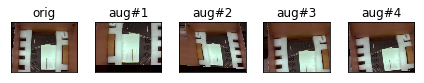

In [38]:
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)
datagen = ImageDataGenerator(**datagen_args)

sid = 150
np.random.seed(42)
image = plt.imread(os.path.join(IMAGE_DIR, "080001.jpg"))
sid += 1
draw_image(sid, image, "orig")
for j in range(4):
    augmented = datagen.random_transform(image)
    sid += 1
    draw_image(sid, augmented, "aug#{:d}".format(j + 1))

plt.tight_layout()
plt.show()

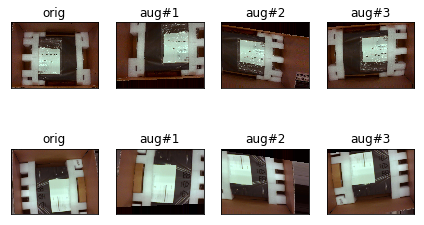

In [37]:
image_pair = ["060003.jpg", "080003.jpg"]

datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]

sid = 240
for i, image in enumerate(image_pair):
    image = plt.imread(os.path.join(IMAGE_DIR, image_pair[i]))
    sid += 1
    draw_image(sid, image, "orig")
    # make sure the two image data generators generate same transformations
    np.random.seed(42)
    for j in range(3):
        augmented = datagens[i].random_transform(image)
        sid += 1
        draw_image(sid, augmented, "aug#{:d}".format(j + 1))

plt.tight_layout()
plt.show()

In [35]:
RESIZE_WIDTH = 300
RESIZE_HEIGHT = 300

def cached_imread(image_path, image_cache):
    if image_path not in image_cache:
        image = plt.imread(image_path)
        image = imresize(image, (RESIZE_WIDTH, RESIZE_HEIGHT))
        image_cache[image_path] = image
    return image_cache[image_path]

def preprocess_images(image_names, seed, datagen, image_cache):
    np.random.seed(seed)
    X = np.zeros((len(image_names), RESIZE_WIDTH, RESIZE_HEIGHT, 3))
    for i, image_name in enumerate(image_names):
        image = cached_imread(os.path.join(IMAGE_DIR, image_name), image_cache)
        X[i] = datagen.random_transform(image)
    return X

def image_triple_generator(image_triples, batch_size):
    datagen_args = dict(rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
    datagen_left = ImageDataGenerator(**datagen_args)
    datagen_right = ImageDataGenerator(**datagen_args)
    image_cache = {}
    
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [image_triples[i] for i in batch_indices]
            # make sure the two image data generators generate same transformations
            seed = np.random.randint(low=0, high=1000, size=1)[0]
            Xleft = preprocess_images([b[0] for b in batch], seed, datagen_left, image_cache)
            Xright = preprocess_images([b[1] for b in batch], seed, datagen_right, image_cache)
            Y = np_utils.to_categorical(np.array([b[2] for b in batch]))
            yield Xleft, Xright, Y

In [36]:
triples_batch_gen = image_triple_generator(image_triples, 32)
Xleft, Xright, Y = triples_batch_gen.__next__()
print(Xleft.shape, Xright.shape, Y.shape)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


(32, 300, 300, 3) (32, 300, 300, 3) (32, 2)
